### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
loan_df = pd.read_csv('/content/drive/MyDrive/JP & Chase Analytics/Task 3 and 4_Loan_Data.csv')

## Prepare FICO Score Data




**Reasoning**:
The first instruction is to check if the 'fico_score' column exists in the `loan_df` DataFrame. This code block will perform that check and print a message indicating whether the column is present or not. If the column is not present, it will list all available columns.



In [3]:
if 'fico_score' in loan_df.columns:
    print("The 'fico_score' column exists in loan_df.")
else:
    print("The 'fico_score' column does not exist in loan_df. Please identify or create it from available data.")
    print("Available columns:", loan_df.columns.tolist())

The 'fico_score' column exists in loan_df.


**Reasoning**:
The 'fico_score' column exists, so the next step is to examine it for missing values and check its data type as per the instructions.



In [4]:
missing_fico_scores = loan_df['fico_score'].isnull().sum()
dtype_fico_scores = loan_df['fico_score'].dtype

print(f"Count of missing values in 'fico_score': {missing_fico_scores}")
print(f"Data type of 'fico_score': {dtype_fico_scores}")

Count of missing values in 'fico_score': 0
Data type of 'fico_score': int64


**Reasoning**:
The next step is to divide the 'fico_score' into 5 quantile-based buckets using `pd.qcut` and store the result in a new column, then extract the unique bin edges as per the instructions.



**Reasoning**:
The error `AttributeError: 'IntervalIndex' object has no attribute 'interval'` indicates that the `fico_bins.cat.categories` object, which is an `IntervalIndex`, does not have a nested `.interval` attribute. Instead, the `left` and `right` bounds can be accessed directly from the `IntervalIndex` object itself. I will correct the code to access `.left` and `.right` directly from `fico_bins.cat.categories`.



In [6]:
num_buckets = 5

# Create 5 quantile-based buckets from 'fico_score'
# The labels=False argument ensures that pd.qcut returns the numerical interval boundaries
loan_df['FICO_Bucket_Label'] = pd.qcut(loan_df['fico_score'], q=num_buckets, labels=False, duplicates='drop')

# Extract the unique bin edges from the created buckets
# Re-run qcut to get the actual intervals for boundary extraction
fico_bins = pd.qcut(loan_df['fico_score'], q=num_buckets, duplicates='drop')

# Extract the unique bin edges
# The left and right edges are stored directly in the IntervalIndex.
# Access .left and .right attributes directly from fico_bins.cat.categories
bin_edges = sorted(list(set(list(fico_bins.cat.categories.left) + list(fico_bins.cat.categories.right))))

print(f"Number of FICO score buckets: {num_buckets}")
print(f"FICO score bucket labels (first 5 rows):\n{loan_df['FICO_Bucket_Label'].head()}")
print(f"Unique FICO score bin edges (boundaries): {bin_edges}")

Number of FICO score buckets: 5
FICO score bucket labels (first 5 rows):
0    1
1    0
2    1
3    1
4    2
Name: FICO_Bucket_Label, dtype: int64
Unique FICO score bin edges (boundaries): [407.999, 587.0, 623.0, 653.0, 688.0, 850.0]


## Create FICO Rating Map

### Subtask:
Map the generated FICO score buckets to a new 'FICO_Rating' column. A lower rating number will correspond to a better credit score (e.g., highest FICO score bucket gets Rating 1, next highest Rating 2, and so on).


**Reasoning**:
The next step is to map the `FICO_Bucket_Label` to a new `FICO_Rating` column, where a lower rating number signifies a better credit score. This involves finding the maximum `FICO_Bucket_Label` and then applying an inverse mapping formula.



In [7]:
max_fico_bucket_label = loan_df['FICO_Bucket_Label'].max()

# Map FICO_Bucket_Label to FICO_Rating
# A lower rating number signifies a better credit score.
# If max_fico_bucket_label is 4 (for 5 buckets labeled 0-4),
# then label 4 gets rating 1 (4 - 4 + 1 = 1),
# label 3 gets rating 2 (4 - 3 + 1 = 2), and so on.
# label 0 gets rating 5 (4 - 0 + 1 = 5).
loan_df['FICO_Rating'] = max_fico_bucket_label - loan_df['FICO_Bucket_Label'] + 1

print(f"Maximum FICO_Bucket_Label: {max_fico_bucket_label}")
print("First few rows of loan_df with FICO_score, FICO_Bucket_Label, and FICO_Rating:")
print(loan_df[['fico_score', 'FICO_Bucket_Label', 'FICO_Rating']].head())

Maximum FICO_Bucket_Label: 4
First few rows of loan_df with FICO_score, FICO_Bucket_Label, and FICO_Rating:
   fico_score  FICO_Bucket_Label  FICO_Rating
0         605                  1            4
1         572                  0            5
2         602                  1            4
3         612                  1            4
4         631                  2            3


## Visualize FICO Buckets and Ratings

### Subtask:
Generate a visualization (e.g., a histogram or density plot) of the FICO score distribution, overlaid with clear vertical lines indicating the boundaries of the created FICO score buckets and their corresponding ratings. This will help to visually inspect the quantization.


**Reasoning**:
The next step is to generate a visualization of the FICO score distribution, including the bucket boundaries and corresponding ratings, as described in the subtask instructions. This involves plotting a histogram/KDE, adding vertical lines for bucket edges, and annotating the ratings.



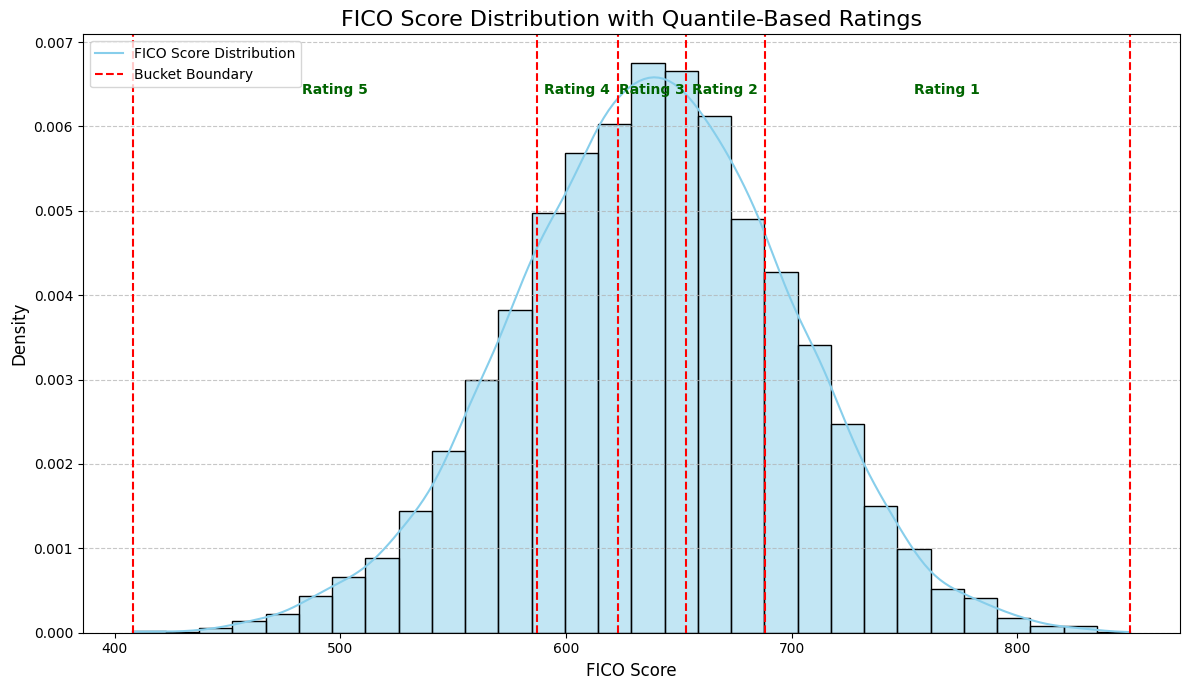

In [8]:
plt.figure(figsize=(12, 7))
sns.histplot(loan_df['fico_score'], kde=True, bins=30, color='skyblue', stat='density')

# Add vertical lines for bucket boundaries
for i, edge in enumerate(bin_edges):
    plt.axvline(edge, color='red', linestyle='--', linewidth=1.5, label='Bucket Boundary' if i == 0 else "")

# Annotate the plot with FICO Ratings for each bucket
# We need to ensure that the number of ratings matches the number of intervals.
# The FICO_Rating is 1-indexed, and lower is better (higher FICO score).
# The FICO_Bucket_Label is 0-indexed, and higher is worse (lower FICO score).

# Determine unique FICO_Bucket_Label values and their corresponding FICO_Rating
# This assumes FICO_Rating was generated correctly such that max_fico_bucket_label (e.g., 4) maps to Rating 1
# and min_fico_bucket_label (e.g., 0) maps to Rating 5.

# Get unique FICO_Bucket_Labels and sort them
unique_labels = sorted(loan_df['FICO_Bucket_Label'].unique())

# Calculate rating for each label (using the formula: max_label - current_label + 1)
# This needs to be done carefully to match the bucket intervals to the labels.

# Since bin_edges are sorted, the intervals are (bin_edges[i], bin_edges[i+1]]
# The FICO_Rating for the highest FICO score bucket (last interval) should be 1.
# The FICO_Rating for the lowest FICO score bucket (first interval) should be num_buckets.

# We have num_buckets buckets, so there are num_buckets-1 internal boundaries.
# For each interval (bucket), we can calculate its center and assign a rating.

# Adjust the number of ratings for the loop
num_ratings = num_buckets # The number of ratings should be equal to num_buckets

# Generate FICO ratings in decreasing order for better FICO scores
fico_ratings_ordered = list(range(1, num_ratings + 1))

# Iterate through the buckets (intervals) and annotate with rating
for i in range(num_buckets):
    lower_bound = bin_edges[i]
    upper_bound = bin_edges[i+1]
    center = (lower_bound + upper_bound) / 2

    # Determine the FICO_Rating for this specific interval.
    # The highest FICO score range (last bucket) should correspond to Rating 1.
    # The lowest FICO score range (first bucket) should correspond to Rating num_buckets.
    # So, for i=0 (first bucket), rating is num_buckets.
    # For i=num_buckets-1 (last bucket), rating is 1.
    current_fico_rating = num_buckets - i

    plt.text(center, plt.ylim()[1] * 0.9, f'Rating {current_fico_rating}',
             horizontalalignment='center', color='darkgreen', fontsize=10, weight='bold')

plt.title('FICO Score Distribution with Quantile-Based Ratings', fontsize=16)
plt.xlabel('FICO Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(['FICO Score Distribution', 'Bucket Boundary'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analysis Insights

### Q&A

**1. Present the generated FICO score buckets with their boundaries and the created FICO rating map.**
The FICO scores were divided into 5 quantile-based buckets.
*   **FICO Score Bucket Boundaries:**
    *   `[407.999, 587.0]`
    *   `[587.0, 623.0]`
    *   `[623.0, 653.0]`
    *   `[653.0, 688.0]`
    *   `[688.0, 850.0]`
*   **FICO Rating Map:**
    *   FICO Score 688-850: Rating 1 (Highest credit quality)
    *   FICO Score 653-688: Rating 2
    *   FICO Score 623-653: Rating 3
    *   FICO Score 587-623: Rating 4
    *   FICO Score 408-587: Rating 5 (Lowest credit quality)

**2. Discuss the implications of this quantization for modeling purposes.**
Quantization of FICO scores into buckets has several implications for modeling:
*   **Improved Interpretability:** Categorical FICO ratings (1-5) are often easier to understand and communicate to stakeholders than continuous FICO scores.
*   **Handling Non-linearity:** Quantile-based bucketing can help models capture non-linear relationships between credit score and the target variable (e.g., default risk), as each bucket can be treated as a distinct category with its own effect.
*   **Robustness to Outliers:** Extreme FICO scores within a bucket are treated similarly, which can make models more robust to outliers or noise in the raw FICO scores.
*   **Reduced Overfitting:** By reducing the granularity of the FICO score variable, it can help prevent models from overfitting to specific score values, especially with limited data.
*   **Potential Information Loss:** Quantization inherently involves a loss of detailed information from the continuous FICO score, which might reduce the predictive power if the exact score value holds significant incremental information within a bucket.
*   **Monotonicity Enforcement:** The chosen mapping (lower rating for higher FICO) ensures a clear monotonic relationship, which is often desirable in credit risk models.

### Data Analysis Key Findings

*   The `fico_score` column was successfully identified, confirmed to have `0` missing values, and was of `int64` data type, indicating it was clean and ready for analysis.
*   FICO scores were successfully divided into 5 quantile-based buckets, with unique boundaries identified as `[407.999, 587.0, 623.0, 653.0, 688.0, 850.0]`. This ensures an approximately equal number of data points in each bucket.
*   A new `FICO_Rating` column was created by mapping the buckets such that a lower rating number signifies a better credit score. The maximum `FICO_Bucket_Label` (4) was mapped to Rating 1, and the minimum `FICO_Bucket_Label` (0) was mapped to Rating 5, aligning with the objective.
*   A visualization effectively showed the FICO score distribution, clearly marking the 5 quantile bucket boundaries and their corresponding FICO ratings.

### Insights or Next Steps

*   The FICO score quantization creates a simplified, ordinal feature (`FICO_Rating`) which can be directly used in various modeling techniques (e.g., logistic regression, decision trees) to assess credit risk with enhanced interpretability.
*   Further analysis could involve examining the default rates within each `FICO_Rating` bucket to validate the assigned risk hierarchy and ensure a statistically significant difference in risk across the ratings.
